In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.decomposition import TruncatedSVD

from sentence_transformers import SentenceTransformer

import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier

In [2]:
data_path = "./data/startup_fate/startup_train.csv"
data = pd.read_csv(data_path, index_col="index")
data

,name,overview,category_code,tag_list,country_code,num_prev_rounds,has_raised_amount,ln_raised_amount,participants,previous_any_founder_experience,ipo_prob,ma_prob,has_next_round
index,,,,,,,,,,,,,
0,Stackdriver,Stackdriver provides a [powerfully simple moni...,enterprise,"application-management, cloud-monitoring, moni...",USA,1,1,15.424948,1,0,0.024390,0.182927,1
1,Authix Tecnologies,Authix Tecnologies is a Torino based start-up ...,security,authentication-solution,GRC,1,1,13.340052,1,0,0.000000,0.000000,1
2,Lytics,Lytics provides B2C marketers the first analyt...,software,"analytics, big-data, data-science, bigdata",USA,2,1,14.603968,5,0,0.021505,0.242105,0
3,1World Online,1World Online is a Silicon Valley-based startu...,enterprise,"social-research, big-data, analytics, mobile",USA,1,1,13.815511,1,0,0.000000,0.000000,0
4,Enure Networks,"Enure Networks, Ltd. provides home-network man...",software,NaN,ISR,1,1,15.894952,2,0,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5507,ice,Ice.com is one of the leading e-commerce websi...,ecommerce,"jewelry, ecommerce",USA,1,1,17.665658,1,0,0.000000,0.013889,0
5508,Course Hero,Course Hero is a digital learning platform tha...,education,"social-learning-network, online-courses, onlin...",USA,2,1,14.220976,6,0,0.010811,0.128342,0
5509,DVS Sciences,"DVS Sciences, Inc. manufactures and has global...",manufacturing,NaN,USA,1,1,16.496532,3,0,0.000000,0.106667,0


In [3]:
test_path = "./data/startup_fate/startup_test.csv"
test = pd.read_csv(test_path, index_col="index")

In [4]:
sample_submission_path = "./data/house_prices/house_price_sample_submission.csv"
sample_submission = pd.read_csv(sample_submission_path, index_col="id")

In [5]:
data["overview"] = data["overview"].fillna("")
data["tag_list"] = data["tag_list"].fillna("")

In [6]:
data["raised_amount"] = np.expm1(data["ln_raised_amount"])
data["raised_amount/participants"] = data["raised_amount"] / data["participants"]

In [7]:
data["overview_len"] = data["overview"].str.len()

In [8]:
# model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', device="cuda")
# embeddings = model.encode(data["overview"].tolist(), show_progress_bar=True, batch_size=32)

# svd_overview = TruncatedSVD(n_components=8, n_iter=10, random_state=42)
# svd_overview.fit(embeddings)
# embeddings = svd_overview.transform(embeddings)

# embeddings = pd.DataFrame(embeddings, columns=[f"emb_overview_{i}" for i in range(embeddings.shape[1])])
# data = pd.concat([data, embeddings], axis=1)

In [9]:
# embeddings = model.encode(data["tag_list"].tolist(), show_progress_bar=True, batch_size=32)

# svd_tag_list = TruncatedSVD(n_components=8, n_iter=10, random_state=42)
# svd_tag_list.fit(embeddings)
# embeddings = svd_tag_list.transform(embeddings)

# embeddings = pd.DataFrame(embeddings, columns=[f"emb_tag_list_{i}" for i in range(embeddings.shape[1])])
# data = pd.concat([data, embeddings], axis=1)

In [10]:
data.isnull().any()

name                               False
overview                           False
category_code                      False
tag_list                           False
country_code                       False
num_prev_rounds                    False
has_raised_amount                  False
ln_raised_amount                   False
participants                       False
previous_any_founder_experience    False
ipo_prob                           False
ma_prob                            False
has_next_round                     False
raised_amount                      False
raised_amount/participants          True
overview_len                       False
dtype: bool

In [11]:
test["overview"] = test["overview"].fillna("")
test["tag_list"] = test["tag_list"].fillna("")

test["raised_amount"] = np.expm1(test["ln_raised_amount"])
test["raised_amount/participants"] = test["raised_amount"] / test["participants"]

test["overview_len"] = test["overview"].str.len()

# embeddings = model.encode(test["overview"].tolist(), show_progress_bar=True, batch_size=32)
# embeddings = svd_overview.transform(embeddings)
# embeddings = pd.DataFrame(embeddings, columns=[f"emb_overview_{i}" for i in range(embeddings.shape[1])], index=test.index)
# test = pd.concat([test, embeddings], axis=1)

# embeddings = model.encode(test["tag_list"].tolist(), show_progress_bar=True, batch_size=32)
# embeddings = svd_tag_list.transform(embeddings)
# embeddings = pd.DataFrame(embeddings, columns=[f"emb_tag_list_{i}" for i in range(embeddings.shape[1])], index=test.index)
# test = pd.concat([test, embeddings], axis=1)

In [12]:
y = data.pop("has_next_round")
X = data

In [13]:
cat_features = ["category_code", "country_code", "has_raised_amount", "previous_any_founder_experience"]
text_features = ["name", "overview", "tag_list"]

In [14]:
n_splits = 5

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
skf.get_n_splits(X, y)
accuracy = 0

preds_test = [list() for _ in range(n_splits)]

for i, (train_index, val_index) in enumerate(skf.split(X, y)):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_val = X.iloc[val_index]
    y_val = y.iloc[val_index]

    model = CatBoostClassifier(
        iterations=100,
        cat_features=cat_features,
        text_features=text_features,
        eval_metric="Accuracy",
        loss_function="CrossEntropy",
        verbose=200,
        early_stopping_rounds=100,
        task_type="GPU",
        # learning_rate=0.04,
        depth=12,
    )

    model.fit(X_train, y_train, eval_set=(X_val, y_val))

    preds = model.predict(X_val)
    accuracy += accuracy_score(y_val, model.predict(X_val))

    preds_test[i] = model.predict_proba(test)[:, 1]

accuracy / n_splits

0:	learn: 0.6960762	test: 0.5920218	best: 0.5920218 (0)	total: 204ms	remaining: 20.2s
99:	learn: 0.9176684	test: 0.6482321	best: 0.6509519 (89)	total: 20.7s	remaining: 0us
bestTest = 0.6509519492
bestIteration = 89
Shrink model to first 90 iterations.
0:	learn: 0.6865502	test: 0.5693563	best: 0.5693563 (0)	total: 213ms	remaining: 21.1s
99:	learn: 0.9380812	test: 0.6391659	best: 0.6464189 (40)	total: 19.8s	remaining: 0us
bestTest = 0.6464188577
bestIteration = 40
Shrink model to first 41 iterations.
0:	learn: 0.6736961	test: 0.6007260	best: 0.6007260 (0)	total: 173ms	remaining: 17.1s
99:	learn: 0.9390023	test: 0.6588022	best: 0.6678766 (74)	total: 19.5s	remaining: 0us
bestTest = 0.667876588
bestIteration = 74
Shrink model to first 75 iterations.
0:	learn: 0.6650794	test: 0.5834846	best: 0.5834846 (0)	total: 205ms	remaining: 20.3s
99:	learn: 0.9349206	test: 0.6306715	best: 0.6370236 (17)	total: 20.5s	remaining: 0us
bestTest = 0.6370235935
bestIteration = 17
Shrink model to first 18 itera

0.6494923101983865

0.6498567674696794

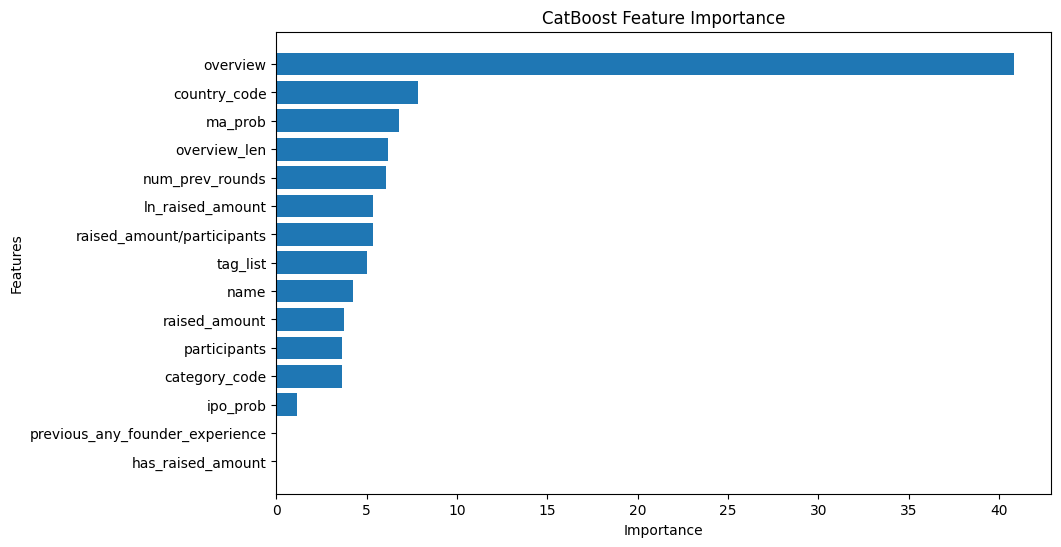

In [15]:
importances = model.get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=X.columns).sort_values()

plt.figure(figsize=(10, 6))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [16]:
preds_test = np.array(preds_test)
preds_test = (preds_test.mean(axis=0) > 0.5).astype(int)

In [17]:
sample_submission_path = "./data/startup_fate/startup_sample_submission.csv"
sample_submission = pd.read_csv(sample_submission_path, index_col="index")
sample_submission

,has_next_round
index,
5512,0
5513,0
5514,0
5515,0
5516,0
...,...
6885,0
6886,0
6887,0


In [18]:
sample_submission["has_next_round"] = preds_test

In [19]:
save_path = "./data/startup_fate/submissions/sub_5.csv"
sample_submission.to_csv(save_path)